In [0]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime

% matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
os.chdir('/content')
from google.colab import files
keys = files.upload()

Saving ssh.tar.gz to ssh.tar.gz


In [4]:
!rm -rf /root/.ssh
!mkdir /root/.ssh

!tar xvzf ssh.tar.gz

!cp ssh-colab/* /root/.ssh && rm -rf ssh-colab
!chmod 700 /root/.ssh

!touch /root/.ssh/known_hosts
!ssh-keyscan github.com >> /root/.ssh/known_hosts
!chmod 644 /root/.ssh/known_hosts

ssh-colab/
ssh-colab/config
ssh-colab/id_rsa_colab
ssh-colab/id_rsa_colab.pub
# github.com:22 SSH-2.0-babeld-a69101e9
# github.com:22 SSH-2.0-babeld-a69101e9
# github.com:22 SSH-2.0-babeld-a69101e9


In [5]:
!ssh-agent /bin/bash

bash: cannot set terminal process group (146): Inappropriate ioctl for device
bash: no job control in this shell
]0;root@6407b106eaa9: /contentroot@6407b106eaa9:/content# ssh-add /root/.ssh/id_rsa_colab
Identity added: /root/.ssh/id_rsa_colab (/root/.ssh/id_rsa_colab)
]0;root@6407b106eaa9: /contentroot@6407b106eaa9:/content# ssh-add -l
2048 SHA256:SpU/DuMOwLsZmS9hdQfImWud0o5YhuYTkxLgNOtF1aA /root/.ssh/id_rsa_colab (RSA)
]0;root@6407b106eaa9: /contentroot@6407b106eaa9:/content# exit
exit


In [0]:
!git config --global user.email 'rashmi.raviprasad@gmail.com'
!git config --global user.name 'rashmi-raviprasad'

In [0]:
IMAGE_DIRECTORY = '/content/drive/My Drive/Springboard DS Course/CAPSTONE 2/IMAGES/NEW_FINAL_PICS'
REPOSITORY = '/content/drive/My Drive/Springboard DS Course/REPOSITORY/springboard'
os.chdir(REPOSITORY+'/faces_capstone2')

In [0]:
from keras.models import Sequential

class Decoder(Sequential):
  def load_data(self, directory=None):
    seed = 42
    np.random.seed(seed)
    self.all_imgs = []
    y_train = []
    y_valid = []
    file_list = os.listdir(IMAGE_DIRECTORY)
    np.random.shuffle(file_list)
    try:
      for file in tqdm(file_list[:25]):
        fn = IMAGE_DIRECTORY + '/' + file
        img = cv2.imread(fn)
        rgb_image =  cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        self.all_imgs.append(rgb_image.astype(np.float32) / 255.)
    except:
      print(file)
    np.random.shuffle(self.all_imgs)
    x_all = np.arange(len(self.all_imgs))
    self.all_dim = np.asarray(self.all_imgs).shape[0]
    TRAIN_DIM = np.asarray(y_train).shape[0]
    VALID_DIM = np.asarray(y_valid).shape[0]
    self.x = np.array(x_all)
    self.y = np.array(self.all_imgs)
  def build_model(self, n_components, model_filename, log_filename, decoder=None):
    decoder = Sequential()
    decoder.add(Embedding(input_dim=self.all_dim, output_dim=n_components, input_length=1))
    decoder.add(Flatten())
    decoder.add(Reshape((1, 1, n_components)))
    decoder.add(Conv2DTranspose(filters=64, kernel_size=3, strides=1, activation='relu'))
    decoder.add(Conv2DTranspose(filters=64, kernel_size=3, strides=1, activation='relu'))
    decoder.add(Conv2DTranspose(filters=32, kernel_size=3, strides=1, activation='relu'))
    decoder.add(Conv2DTranspose(filters=32, kernel_size=3, strides=2, activation='relu'))
    decoder.add(Conv2DTranspose(filters=16, kernel_size=3, strides=2, activation='relu'))
    decoder.add(Conv2DTranspose(filters=16, kernel_size=3, strides=2, activation='relu'))
    decoder.add(Conv2DTranspose(filters=8, kernel_size=3, strides=2, activation='relu'))
    decoder.add(Conv2DTranspose(filters=3, kernel_size=4, strides=2, activation='sigmoid'))
    decoder.compile(optimizer='adam', loss='mse')
    self.model_filename = model_filename
    decoder.save(self.model_filename)
    self.decoder = decoder
    data_dict = {'Date':[datetime.now()], 'Run_Number':[0], 'Num_Epochs_Tot':[0]}
    train_log = pd.DataFrame.from_dict(data_dict)
    self.log_filename = log_filename
    train_log.to_csv(self.log_filename)
  def fit_model(self, i, batch_size, n_epochs):
    model = load_model(self.model_filename)
    model.fit(self.x, self.y, batch_size=batch_size, epochs=n_epochs, validation_split=0.2)
    model.save(self.model_filename)
    train_log = pd.read_csv(self.log_filename)
    data_dict = {'Date':[datetime.now()], 'Run_Number':[i+1], 'Num_Epochs_Tot':[N_EPOCHS*(i+1)]}
    train_log = train_log.append(data_dict, ignore_index=True)
    train_log.to_csv(self.log_filename)
  def predict_model(self, batch_size):
    self.decoder = load_model(self.model_filename)
    return self.decoder.predict(self.x, batch_size=batch_size)

In [0]:
def save_to_git(commit_msg):
  os.chdir(REPOSITORY)
  os.environ['MSG'] = commit_msg
  !git pull
  !git add .
  !git commit -m $MSG
  !git push

In [12]:
decoder_model = Decoder()
decoder_model.load_data()

100%|██████████| 25/25 [00:09<00:00,  3.69it/s]


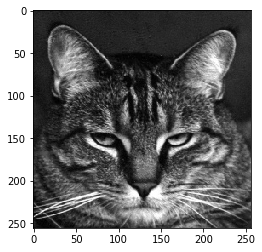

25


In [27]:
plt.imshow(decoder_model.all_imgs[21])
plt.show()
print(len(decoder_model.all_imgs))

In [28]:
#from keras.models import Sequential
from keras.layers import Activation, Input, Flatten, Reshape
from keras.layers.convolutional import Conv2DTranspose
from keras.layers.embeddings import Embedding
from keras.callbacks import TensorBoard
from keras import backend as K
K.set_image_data_format('channels_last')
K.clear_session()

In [29]:
BATCH_SIZE = 10
N_COMPONENTS = 100
MODEL_FN = 'decoder.h5'
LOGS_FN = 'train_log.csv'
N_EPOCHS = 5

decoder_model.build_model(N_COMPONENTS, MODEL_FN, LOGS_FN)

In [0]:
from keras.models import load_model

N_LOOPS = 20
for i in range(N_LOOPS):
  os.chdir(REPOSITORY+'/faces_capstone2')
  print('Training Batch # %d' % (i+1))
  decoder_model.fit_model(i, BATCH_SIZE, N_EPOCHS)
  message = 'trained %d of %d epochs' % (N_EPOCHS, N_EPOCHS*N_LOOPS)
  message = message.replace(' ', '_')
  save_to_git(message)
  print('Trained %d epochs for total of %d epochs' % (N_EPOCHS, N_EPOCHS*(i+1)))


Training Batch # 1


Train on 20 samples, validate on 5 samples
Epoch 1/5
20/20 [==============================] - 6s 320ms/step - loss: 0.0912 - val_loss: 0.0748
Epoch 2/5
20/20 [==============================] - 0s 1ms/step - loss: 0.0695 - val_loss: 0.0707
Epoch 3/5
20/20 [==============================] - 0s 1ms/step - loss: 0.0556 - val_loss: 0.0690
Epoch 4/5
20/20 [==============================] - 0s 1ms/step - loss: 0.0489 - val_loss: 0.0647
Epoch 5/5
20/20 [==============================] - 0s 1ms/step - loss: 0.0468 - val_loss: 0.0627
Already up to date.
[master 8e0364c] trained_5_of_100_epochs
 5 files changed, 28 insertions(+), 25 deletions(-)
 create mode 100644 decoder.h5
 rewrite faces_capstone2/decoder.h5 (78%)
 rewrite faces_capstone2/faces_decoder.ipynb (90%)
 rewrite faces_capstone2/train_log.csv (67%)
 create mode 100644 train_log.csv
Counting objects: 8, done.
Delta compression using up to 4 threads.
Compressing objects: 100% (8/8), done.
Writing objects: 100% (8/8

In [0]:
os.chdir(REPOSITORY+'/faces_capstone2')
compressed = decoder_model.predict_model(batch_size=BATCH_SIZE)

25


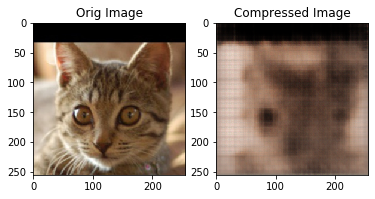

In [0]:
PIC = np.random.choice(50)
print(PIC)
plt.subplot(1,2,1)
plt.imshow(decoder_model.all_imgs[PIC])
plt.title('Orig Image')

plt.subplot(1,2,2)
plt.imshow(compressed[PIC])
plt.title('Compressed Image')

plt.show()

In [7]:
save_to_git('test_commit')

Already up to date.
[master 6d2f17a] test_commit
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite faces_capstone2/faces_decoder.ipynb (95%)
Counting objects: 4, done.
Delta compression using up to 4 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 1.29 KiB | 189.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To github.com:rashmi-raviprasad/springboard.git
   579bcaf..6d2f17a  master -> master
